## Analyzing Time Series Data

This script contains:

Importing libraries and data

Subsetting, Groping and Indexing

Time series analysis: decomposition

Testing for stationarity

### Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [2]:
# Importing cleaned data
path = r'/Users/jennyfevik/Desktop/Data'

In [3]:
df_border = pd.read_csv(os.path.join(path, 'Prepared', 'Border_Regression.csv'),index_col=0)

In [4]:
df_border.head()

,Port Name,State,Border,Crossing Method,Count of Crossing,Latitude,Longitude,Month,Year,Count Category,State Total,Month Code,Month Total
0,Del Rio,Texas,US-Mexico Border,Trucks,5823,29.327,-100.928,Feb,2023,Low Crossings,4076706895,1.0,822883011
2,Skagway,Alaska,US-Canada Border,Pedestrians,1,59.630,-135.164,Feb,2023,Low Crossings,15399123,1.0,822883011
3,Brownsville,Texas,US-Mexico Border,Trains,70,25.952,-97.401,Feb,2023,Low Crossings,4076706895,1.0,822883011
4,Sault Sainte Marie,Michigan,US-Canada Border,Truck Containers Loaded,2322,46.509,-84.361,Feb,2023,Low Crossings,812680737,1.0,822883011
5,Lukeville,Arizona,US-Mexico Border,Pedestrians,6383,31.880,-112.817,Feb,2023,Low Crossings,1008310869,1.0,822883011


### Subsetting, Grouping and Indexing

In [5]:
# Dropping years before 2000
df_sub = df_border.loc[(df_border['Year'] >= 2000) & (df_border['Year'] < 2023)]

Looking back 20 years will provide sufficient data and a cleaner look

In [6]:
df_sub.tail()

,Port Name,State,Border,Crossing Method,Count of Crossing,Latitude,Longitude,Month,Year,Count Category,State Total,Month Code,Month Total
359333,Detroit,Michigan,US-Canada Border,Trains,374,42.332,-83.048,Mar,2001,Low Crossings,812680737,2.0,938287436
360567,Madawaska,Maine,US-Canada Border,Truck Containers Empty,1336,47.360,-68.329,Mar,2001,Low Crossings,244044605,2.0,938287436
360663,Santa Teresa,New Mexico,US-Mexico Border,Personal Vehicles,8431,31.784,-106.679,Feb,2001,Low Crossings,78626869,1.0,822883011
362599,Progreso,Texas,US-Mexico Border,Bus Passengers,3057,26.062,-97.950,Mar,2001,Low Crossings,4076706895,2.0,938287436
362755,Oroville,Washington,US-Canada Border,Personal Vehicles,15282,49.000,-119.462,Dec,2000,Low Crossings,545223771,11.0,910717899


In [7]:
# Combining month and year into one column
df_sub["Date"] = df_sub["Month"] +'-'+ df_sub['Year'].astype(str)

In [8]:
#Changing format of "Date"
from datetime import datetime
pd.to_datetime(df_sub.Date, format = '%b-%Y')

190      2020-03-01
230      2021-04-01
1239     2021-05-01
3077     2021-10-01
3777     2021-06-01
            ...    
359333   2001-03-01
360567   2001-03-01
360663   2001-02-01
362599   2001-03-01
362755   2000-12-01
Name: Date, Length: 221296, dtype: datetime64[ns]

In [9]:
# Subsetting for only date and count of crossing df
df_sub2 = df_sub[['Date','Count of Crossing']]

In [10]:
df_sub2

,Date,Count of Crossing
190,Mar-2020,203861
230,Apr-2021,77
1239,May-2021,131
3077,Oct-2021,5649
3777,Jun-2021,207
...,...,...
359333,Mar-2001,374
360567,Mar-2001,1336
360663,Feb-2001,8431
362599,Mar-2001,3057


In [11]:
# grouping dates
df_sub2_grp = df_sub2.groupby(['Date'])['Count of Crossing'].sum()

In [12]:
df_sub2_grp.shape

(276,)

In [13]:
# Resetting index and re-setting sub-grouping name
df_counts = df_sub2_grp.reset_index()

In [14]:
df_counts.head()

,Date,Count of Crossing
0,Apr-2000,44639294
1,Apr-2001,43731679
2,Apr-2002,37923411
3,Apr-2003,35023987
4,Apr-2004,37343784


In [15]:
# Set the "Date" column as the index

df_counts['datetime'] = pd.to_datetime(df_counts['Date'])
df_counts = df_counts.set_index('datetime')
df_counts.drop(['Date'], axis=1, inplace=True)
df_counts.head()

,Count of Crossing
datetime,
2000-04-01,44639294
2001-04-01,43731679
2002-04-01,37923411
2003-04-01,35023987
2004-04-01,37343784


In [16]:
df_counts.columns

Index(['Count of Crossing'], dtype='object')

In [17]:
df_counts.isnull().sum()

Count of Crossing    0
dtype: int64

In [18]:
type(df_counts)

pandas.core.frame.DataFrame

In [19]:
df_counts = df_counts.sort_index()

<Axes: xlabel='datetime'>

<Figure size 1500x500 with 0 Axes>

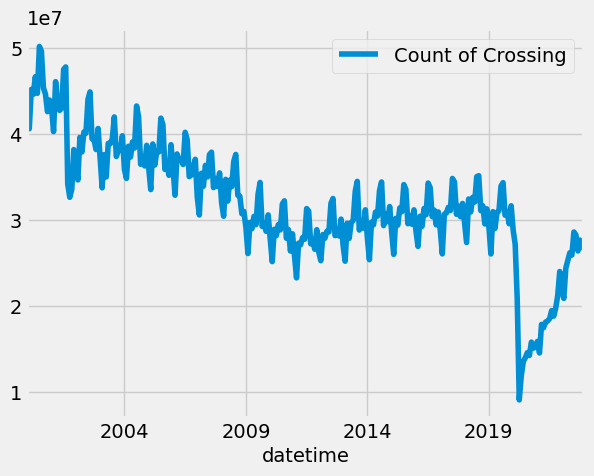

In [20]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
df_counts.plot()

In [21]:
# Check for missing values

df_counts.isnull().sum()

Count of Crossing    0
dtype: int64

In [22]:
# Check for duplicates

dups = df_counts.duplicated()
dups.sum()


0

### Time series analysis - decomposition

In [23]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_counts, model='additive', period=10)

In [24]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

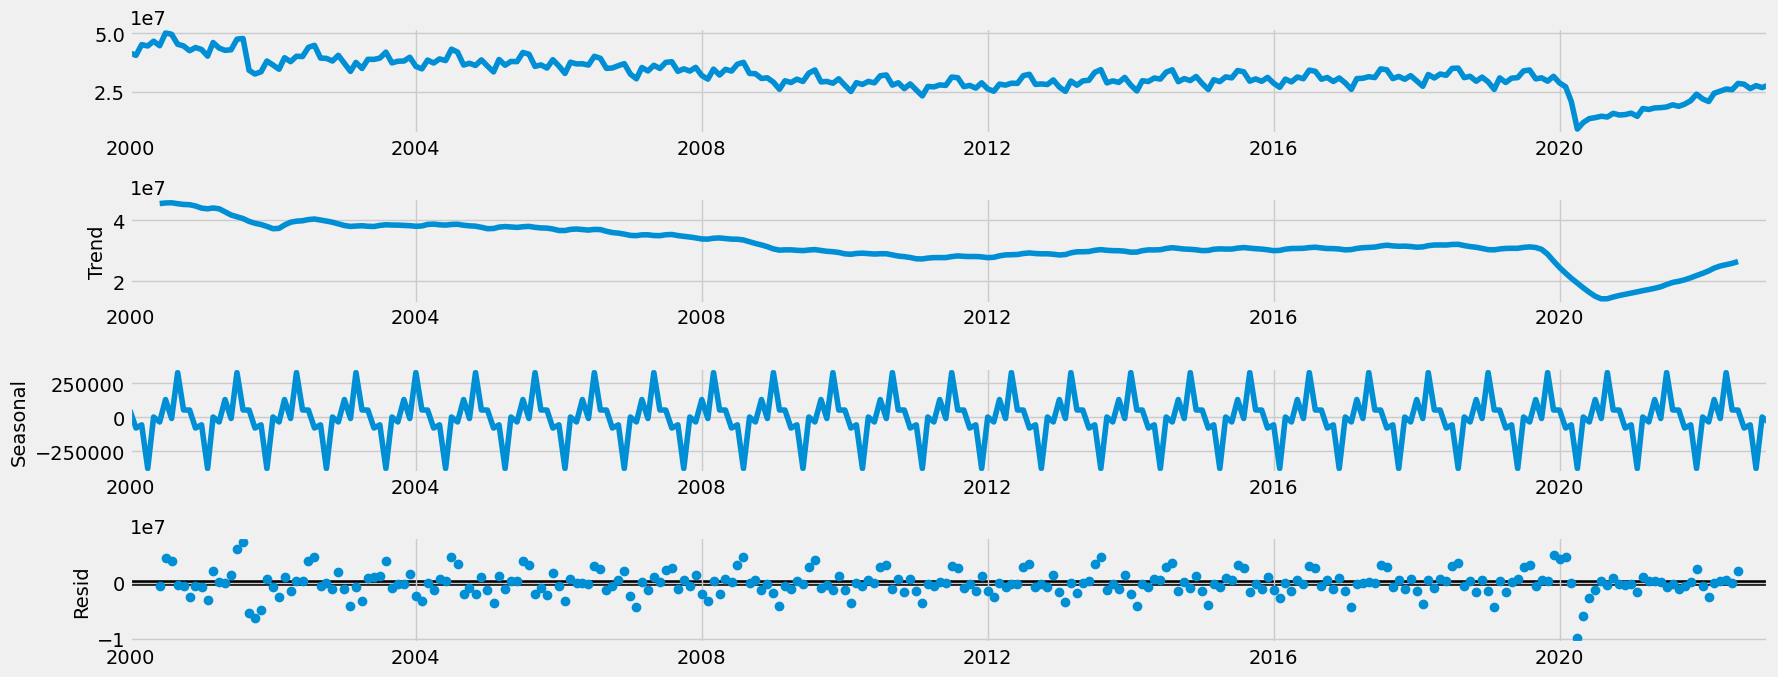

In [25]:
# Plotting the separate components

decomposition.plot()
plt.show()

### Testing for Stationarity

In [26]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)


dickey_fuller(df_counts['Count of Crossing'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.211497
p-value                          0.202099
Number of Lags Used             13.000000
Number of Observations Used    262.000000
Critical Value (1%)             -3.455558
Critical Value (5%)             -2.872636
Critical Value (10%)            -2.572683
dtype: float64


The test statistic is slightly larger than the critical value (5%), so we cannot reject the null hypothesis of the presence of a unit root, indicating the data is non-stationary.

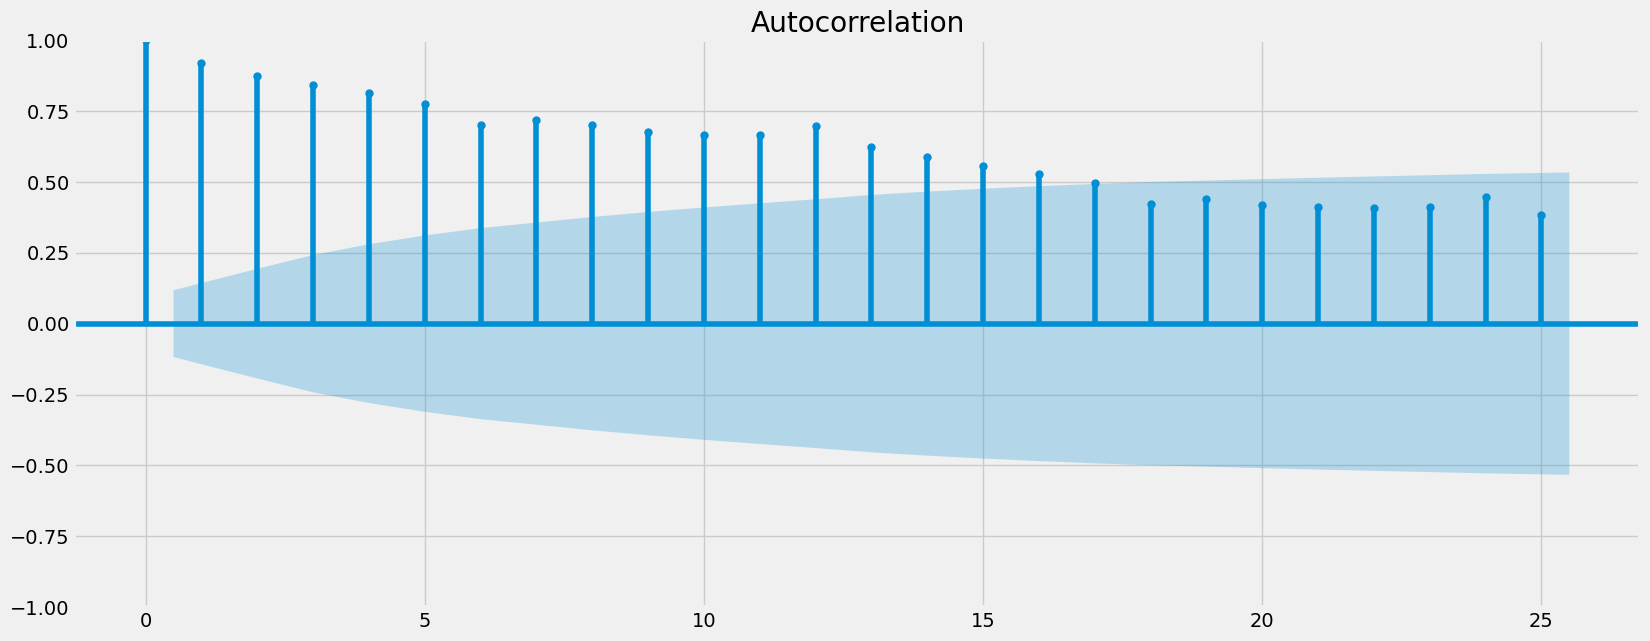

In [27]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_counts)
plt.show()

The autocorrelation test shows many significant lags beyond the the edge of the confidence level, indicating autocorrelations and non-stationary data.

### Stationarizing the data

In [28]:
# Differencing the data
data_diff = df_counts - df_counts.shift(1)

In [29]:
data_diff.dropna(inplace = True)

In [30]:
data_diff.head()

,Count of Crossing
datetime,
2000-02-01,-1059519.0
2000-03-01,4574903.0
2000-04-01,-559462.0
2000-05-01,2038314.0
2000-06-01,-1925036.0


In [31]:
data_diff.columns

Index(['Count of Crossing'], dtype='object')

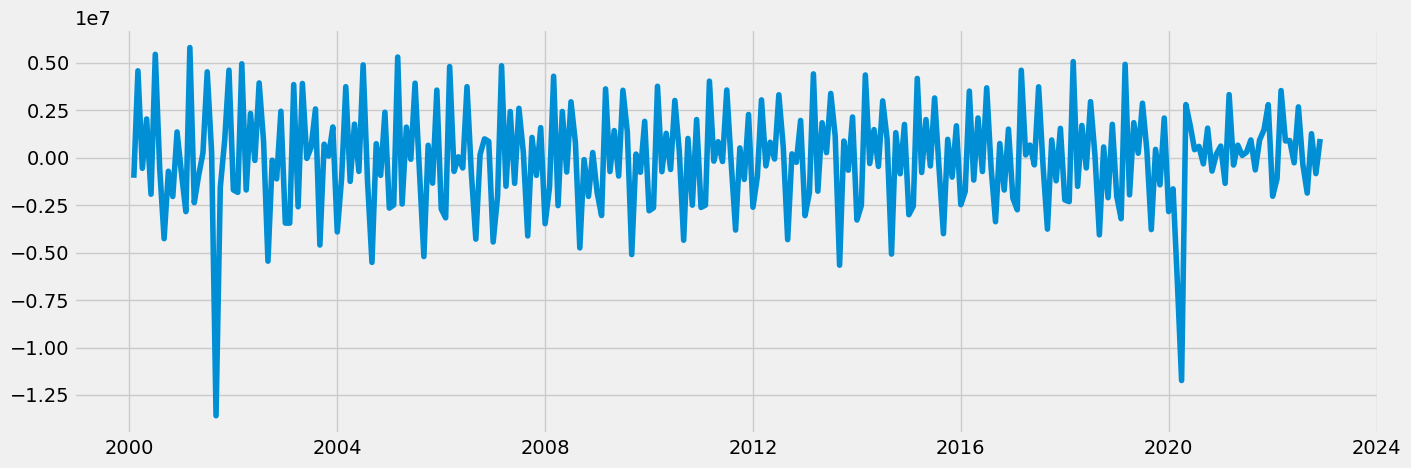

In [32]:
# plotting the differenced data
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [33]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.326285
p-value                          0.000400
Number of Lags Used             12.000000
Number of Observations Used    262.000000
Critical Value (1%)             -3.455558
Critical Value (5%)             -2.872636
Critical Value (10%)            -2.572683
dtype: float64


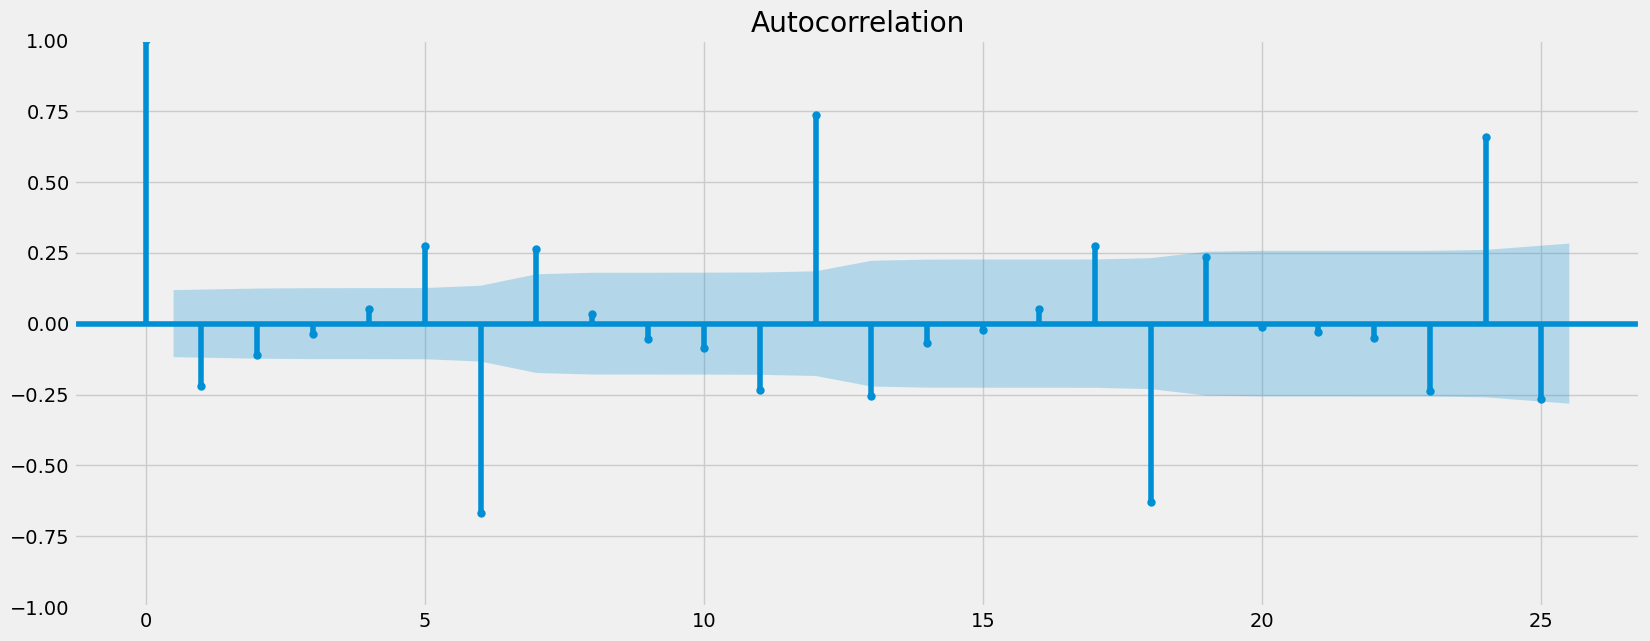

In [34]:
plot_acf(data_diff)
plt.show()

There are still lag lines beyond the confidence level, but less than 10, so the differencing does not need to be run again and the data is now ready for forecasting. 